In [7]:
!nvidia-smi

Sat May 13 22:33:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    34W / 250W |    255MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
!python -m pip install "dask[complete]"    # Install everything
!python -m pip install "dask-ml[complete]"    # Install everything
#!pip install dask
!pip install dask-ml
#!pip install tune-sklearn "ray[tune]"
!pip install bokeh

In [9]:
!pip -q install --upgrade numpy pandas scipy sklearn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cuml 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
ydata-profiling 4.1.2 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.3 which is incompatible.
ydata-profiling 4.1.2 requires pandas!=1.4.0,<1.6,>1.1, but you have pandas 2.0.1 which is incompatible.
ydata-profiling 4.1.2 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.
woodwork 0.23.0 requires pandas<2.0.0,>=1.4.3, but you have pandas 2.0.1 which is incompatible.
wfdb 4.1.0 requires pandas<2.0.0,>=1.0.0, but you have pandas 2.0.1 which is incompatible.
tpot 0.11.7 requires xgboost>=1.1.0, but you have xgboost 0.90 which is incompatible.
tensorflow 2.

In [10]:
!pip -q install numpy==1.23.5
!pip -q install pandas==1.5.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cuml 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
ydata-profiling 4.1.2 requires pandas!=1.4.0,<1.6,>1.1, but you have pandas 2.0.1 which is incompatible.
ydata-profiling 4.1.2 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.
woodwork 0.23.0 requires pandas<2.0.0,>=1.4.3, but you have pandas 2.0.1 which is incompatible.
wfdb 4.1.0 requires pandas<2.0.0,>=1.0.0, but you have pandas 2.0.1 which is incompatible.
tpot 0.11.7 requires xgboost>=1.1.0, but you have xgboost 0.90 which is incompatible.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-s

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra"
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vgg16-cifake/REAL_Test_Features.csv
/kaggle/input/vgg16-cifake/Fake_Train_Features.csv
/kaggle/input/vgg16-cifake/Fake_Test_Features.csv
/kaggle/input/vgg16-cifake/Real_Train_Features.csv


In [12]:
import cudf
from cuml.svm import SVC
#from sklearn.svm import SVC
import seaborn as sns
import dask
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask.distributed import LocalCluster
import dask.dataframe as dd
from dask.utils import parse_bytes
#from tune_sklearn import TuneGridSearchCV
from dask_ml.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from time import time


In [13]:
df_train = pd.read_csv("/kaggle/input/vgg16-cifake/Fake_Train_Features.csv")
df_train.head(3)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,503,504,505,506,507,508,509,510,511,class
0,0,0.000000,14.317362,0.0,29.562464,0.000000,39.905197,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,Fake
1,1,0.000000,0.000000,0.0,0.000000,10.574828,22.795412,0.0,0.000000,0.0,...,15.529102,0.0,0.0,0.0,0.0,29.724674,0.0,0.000000,18.845003,Fake
2,2,6.629343,0.000000,0.0,0.000000,13.008339,0.000000,0.0,41.318874,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.707935,0.000000,Fake


In [14]:
df_train_r = pd.read_csv("/kaggle/input/vgg16-cifake/Real_Train_Features.csv")
df_train_r.head(3)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,503,504,505,506,507,508,509,510,511,class
0,0,27.489744,0.0,0.0,0.000000,0.0,4.406033,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,3.239264,5.528229,0.0,0.0,0.0,Real
1,1,0.000000,0.0,0.0,27.298634,0.0,21.718521,17.45442,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,22.730530,0.0,0.0,0.0,Real
2,2,0.000000,0.0,0.0,0.000000,0.0,7.493243,0.00000,1.344108,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,Real


In [15]:
df = pd.concat([df_train,df_train_r],axis=0)
df

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,503,504,505,506,507,508,509,510,511,class
0,0,0.000000,14.317362,0.000000,29.562464,0.000000,39.905197,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,Fake
1,1,0.000000,0.000000,0.000000,0.000000,10.574828,22.795412,0.000000,0.000000,0.0,...,15.529102,0.000000,0.0,0.0,0.0,29.724674,0.000000,0.000000,18.845003,Fake
2,2,6.629343,0.000000,0.000000,0.000000,13.008339,0.000000,0.000000,41.318874,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.707935,0.000000,Fake
3,3,0.000000,33.488865,0.000000,0.000000,0.000000,43.813812,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,Fake
4,4,0.000000,0.000000,0.000000,0.000000,7.101869,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,27.029570,Fake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,Real
49996,49996,52.616604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,24.642124,0.000000,0.000000,Real
49997,49997,0.000000,0.000000,1.115253,0.000000,20.490191,0.000000,0.000000,0.000000,0.0,...,1.229562,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,23.144651,Real
49998,49998,0.000000,0.000000,0.000000,24.077782,0.000000,12.758121,16.457981,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,62.473804,0.000000,0.000000,0.000000,Real


In [16]:
df_sample = df.sample(frac=1.0, random_state=0)
df_sample.head(3)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,503,504,505,506,507,508,509,510,511,class
3582,3582,0.00000,0.0,0.0,0.000000,30.496098,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,Fake
10498,10498,9.27322,0.0,0.0,40.926361,0.000000,36.769344,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,Real
3227,3227,0.00000,0.0,0.0,0.000000,0.000000,36.534424,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18.101137,0.0,0.0,49.346546,Real


In [17]:
X = df_sample.drop('class', axis=1)

le = LabelEncoder()
y = df_sample['class']
y = pd.DataFrame(le.fit_transform(y), columns=['class'])  # encode y to be numeric

y.head()

,class
0,0
1,1
2,1
3,0
4,0


In [18]:
stnd = StandardScaler()
stnd.fit(X)
X = pd.DataFrame(stnd.transform(X), columns = X.columns)

In [19]:
X_dask = dd.from_pandas(X, npartitions=1)
y_dask = dd.from_pandas(y, npartitions=1)

In [20]:
cluster = LocalCluster(n_workers=1,memory_limit='14GB',dashboard_address=None)
client = Client(cluster)
client


2023-05-13 22:35:24,784 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 14GB due to system memory limit of 13.00 GiB


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 2,Total memory: 13.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46353,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 13.00 GiB
Comm: tcp://127.0.0.1:34655,Total threads: 2
Dashboard: http://127.0.0.1:35165/status,Memory: 13.00 GiB
Nanny: tcp://127.0.0.1:36795,


In [21]:
with cluster:
    with Client(cluster) as client:

        grid = {
            'C': [1, 2, 3, 3.5, 4, 4.5, 5, 5.5, 6, 7, 8, 9, 10, 11, 12],
            'gamma': [.0012, .0015, .0017, .002, .00225, .0025]
        }

        time_start = time()

        svm = SVC(kernel='rbf')
        svmCV = GridSearchCV(svm, grid, return_train_score=True)
        svmCV.fit(X_dask, y_dask)

        time_stop = time()
        print(f"Time elapsed: {(time_stop - time_start) / 60.0:.2f} minutes")

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Time elapsed: 63.06 minutes


In [22]:
client.close()
cluster.close()

In [23]:
svmCV.best_score_

0.9057400064784289

In [24]:
svmCV.best_params_

{'C': 4, 'gamma': 0.002}

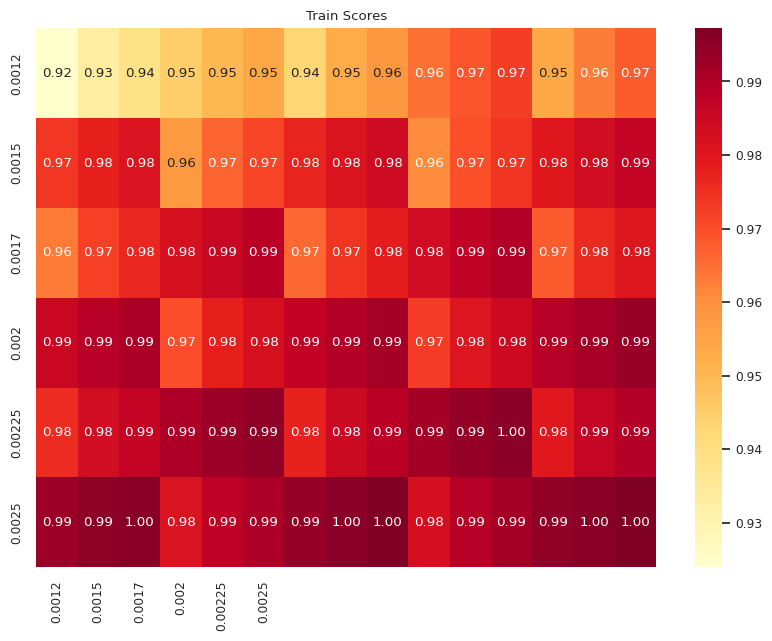

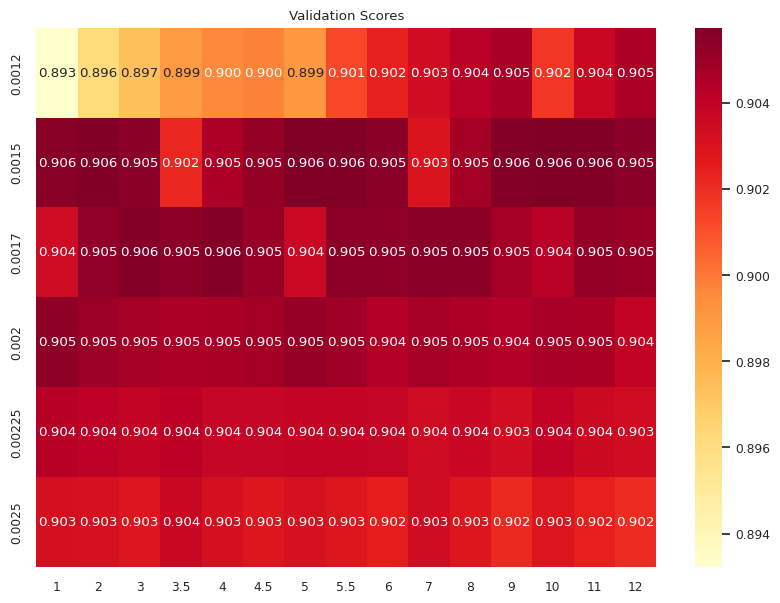

In [25]:
# Extract the hyperparameters, scores, and create a results dataframe
results = pd.DataFrame(svmCV.cv_results_)
gamma = results['param_gamma'].unique()
C = results['param_C'].unique()
train = np.array(results['mean_train_score']).reshape(len(gamma), len(C))
valid = np.array(results['mean_test_score']).reshape(len(gamma), len(C))

# Create a heatmap of the results
sns.set(style='whitegrid', font_scale=.8)
fig, ax = plt.subplots(figsize=(10, 7))
ax.set(xlabel='C', ylabel='Gamma', title='Train Scores')
sns.heatmap(train, annot=True, fmt='.2f', cmap='YlOrRd', xticklabels=gamma, yticklabels=gamma)
plt.show()

sns.set(style='whitegrid', font_scale=.8)
fig, ax = plt.subplots(figsize=(10, 7))
ax.set(xlabel='C', ylabel='Gamma', title='Validation Scores')
sns.heatmap(valid, annot=True, fmt='.3f', cmap='YlOrRd', xticklabels=C, yticklabels=gamma)
plt.show()